# DReS-FL Experiment 

- K = 1
- T = 1
- input dimension = [2, 3, 4, 5, 6, 7, 8, 9, 10]
- linear regression
- w = [1 1]
- finite field size = 23
- inputs are selected from {0, 1}
- no relationship between x and y
- the gradient is supposed to be revealed at the end of each training round

Basically, our objective function is $l = (y - xw)^2$ and our gradient is $g = -2(xy - x^2w)$ 

In [1]:
import numpy as np
from lcc.polynomials import LCCPoly, InterpolatedPoly
from mutual_information.estimators.neural.benchmark import neural_estimator_benchmark

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
def create_encoded_dataset(encoded_data_pol, data_size, encoded_label_pol, alpha):
    encoded_data = np.empty((len(encoded_data_pol), *data_size)) 
    encoded_label = np.empty((len(encoded_label_pol), 1))
    for idx, (data_pol, label_pol) in enumerate(zip(encoded_data_pol, encoded_label_pol)):
        encoded_data[idx] = data_pol(alpha)
        encoded_label[idx][0] = label_pol(alpha)
    return encoded_data, encoded_label

def calculate_gradient_samplewise(encoded_data, encoded_label, curr_weight, p):
    # g = -2(xy - x^2w)
    gradient = np.empty((encoded_data.shape[0], *curr_weight.shape))
    for idx in range(encoded_data.shape[0]):
        data, label = encoded_data[idx], encoded_label[idx]
        gradient[idx] = (label - (data.T @ curr_weight)[0][0]) % p
        gradient[idx] = (data * gradient[idx]) % p
        gradient[idx] = (-2 * gradient[idx]) % p
    gradient = gradient.astype(int)
    return gradient

def main_mi_calculation(data_range, prime, para_param, priv_param, num_of_samples, beta_arr, alpha_arr, weight, feature_size):
    secret_data = np.random.randint(low=0, high=data_range, size=(num_of_samples, feature_size, 1))
    secret_label = np.random.randint(low=0, high=data_range, size=(num_of_samples, 1))
    encoded_secret_data_pol = [LCCPoly(beta_arr, [x], para_param, priv_param, prime, size=(feature_size, 1)) for x in secret_data]
    encoded_secret_label_pol = [LCCPoly(beta_arr, [x[0]], para_param, priv_param, prime) for x in secret_label]
    print('pols created')
    
    # client 0
    client_0_encoded_data, client_0_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (feature_size, 1), encoded_secret_label_pol, alpha_arr[0])
    client_0_encoded_gradient = calculate_gradient_samplewise(client_0_encoded_data, client_0_encoded_label, weight, prime)
    
    # client 1
    client_1_encoded_data, client_1_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (feature_size, 1), encoded_secret_label_pol, alpha_arr[1])
    client_1_encoded_gradient = calculate_gradient_samplewise(client_1_encoded_data, client_1_encoded_label, weight, prime)
    
    # client 2
    client_2_encoded_data, client_2_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (feature_size, 1), encoded_secret_label_pol, alpha_arr[2])
    client_2_encoded_gradient = calculate_gradient_samplewise(client_2_encoded_data, client_2_encoded_label, weight, prime)
    print('gradient calculation for each client done')
    
    revealed_gradients = np.empty(client_0_encoded_data.shape)
    revealed_random = np.empty(client_0_encoded_gradient.shape)
    revealed_poly_constructed_coeff = np.empty((client_0_encoded_gradient.shape[0], 2 * (para_param + priv_param - 1) + 1, client_0_encoded_gradient.shape[1], client_0_encoded_gradient.shape[2]))
    for gradient_idx in range(client_0_encoded_gradient.shape[0]):
        revealed_poly = InterpolatedPoly([client_0_encoded_gradient[gradient_idx], client_1_encoded_gradient[gradient_idx], client_2_encoded_gradient[gradient_idx]], alpha_arr, prime)
        revealed_gradients[gradient_idx] = revealed_poly(beta_arr[0])
        revealed_random[gradient_idx] = revealed_poly(beta_arr[1])
        revealed_poly_constructed_coeff[gradient_idx] = revealed_poly.coefficients
    
    # create dataset
    resulting_dataset = np.concatenate([secret_data.reshape(num_of_samples, -1), secret_label, revealed_gradients.reshape(num_of_samples, -1), revealed_random.reshape(num_of_samples, -1), revealed_poly_constructed_coeff.reshape(num_of_samples, -1)], axis=1)
    print('dataset is created')
    
    estimators_all, results_all = neural_estimator_benchmark(resulting_dataset[:, :(feature_size + 1)], resulting_dataset[:, (3 * feature_size + 1):])
    estimators_revealed_gradient, results_revealed_gradient = neural_estimator_benchmark(resulting_dataset[:, :(feature_size + 1)], resulting_dataset[:, (feature_size + 1):(2 * feature_size + 1)])
    return estimators_all, results_all, estimators_revealed_gradient, results_revealed_gradient

In [4]:
feature_arr = list(range(2, 11))
prime_arg = 23
data_range_arg = 2
para_param_arg = 1 # K
priv_param_arg = 1 # T

num_of_samples_arg = 10000
beta_arr_arg = [0, 1]
alpha_arr_arg = [2, 3, 4] # number of clients = 3

result_arr = []

for feature_size_arg in feature_arr:
    weight_arg = np.ones((feature_size_arg, 1))
    print('###########################')
    print('exp feature size: {}'.format(feature_size_arg))
    result_arr.append(main_mi_calculation(data_range_arg, prime_arg, para_param_arg, priv_param_arg, num_of_samples_arg, beta_arr_arg, alpha_arr_arg, weight_arg, feature_size_arg))
    print('###########################\n')

###########################
exp feature size: 2
pols created
gradient calculation for each client done
dataset is created


 22%|███████████▉                                         | 2250/10000 [04:48<16:32,  7.81step/s, test=2.02, train=2.02]


Donker Varadhan estimator: 2.02


 22%|███████████▋                                        | 2250/10000 [00:11<00:40, 192.18step/s, test=1.97, train=2.05]


MINE estimator: 2.01


 20%|██████████▌                                          | 2000/10000 [04:13<16:54,  7.88step/s, test=2.02, train=2.02]


InfoNCE estimator: 2.02


 32%|█████████████████▏                                   | 3250/10000 [06:30<13:30,  8.33step/s, test=2.02, train=2.00]


NWJ estimator: 2.03


 20%|██████████▌                                          | 2000/10000 [03:53<15:32,  8.58step/s, test=1.38, train=1.36]


Donker Varadhan estimator: 1.38


  8%|███▉                                                 | 750/10000 [00:02<00:35, 258.13step/s, test=1.37, train=1.56]


MINE estimator: 1.44


  8%|████                                                  | 750/10000 [01:14<15:23, 10.01step/s, test=1.38, train=1.34]


InfoNCE estimator: 1.38


 20%|██████████▌                                          | 2000/10000 [03:18<13:15, 10.06step/s, test=1.38, train=1.37]


NWJ estimator: 1.38
###########################

###########################
exp feature size: 3
pols created
gradient calculation for each client done
dataset is created


 30%|███████████████▉                                     | 3000/10000 [05:02<11:46,  9.91step/s, test=2.71, train=2.73]


Donker Varadhan estimator: 2.72


 20%|██████████▍                                         | 2000/10000 [00:07<00:28, 277.89step/s, test=2.72, train=2.75]


MINE estimator: 2.79


 15%|███████▉                                             | 1500/10000 [02:33<14:29,  9.78step/s, test=2.72, train=2.72]


InfoNCE estimator: 2.73


 18%|█████████▎                                           | 1750/10000 [02:58<14:03,  9.79step/s, test=2.70, train=2.77]


NWJ estimator: 2.71


 15%|███████▉                                             | 1500/10000 [02:29<14:06, 10.04step/s, test=2.26, train=2.23]


Donker Varadhan estimator: 2.26


  8%|███▉                                                 | 750/10000 [00:02<00:35, 257.56step/s, test=2.23, train=2.62]


MINE estimator: 2.25


 18%|█████████▎                                           | 1750/10000 [02:54<13:44, 10.01step/s, test=2.27, train=2.22]


InfoNCE estimator: 2.27


 15%|███████▉                                             | 1500/10000 [02:29<14:08, 10.01step/s, test=2.25, train=2.22]


NWJ estimator: 2.26
###########################

###########################
exp feature size: 4
pols created
gradient calculation for each client done
dataset is created


 10%|█████▎                                               | 1000/10000 [01:50<16:32,  9.07step/s, test=3.37, train=3.43]


Donker Varadhan estimator: 3.38


 18%|█████████                                           | 1750/10000 [00:06<00:29, 277.49step/s, test=3.29, train=3.36]


MINE estimator: 3.34


 10%|█████▎                                               | 1000/10000 [01:51<16:42,  8.98step/s, test=3.39, train=3.38]


InfoNCE estimator: 3.40


 15%|███████▉                                             | 1500/10000 [02:44<15:34,  9.09step/s, test=3.35, train=3.44]


NWJ estimator: 3.38


 20%|██████████▌                                          | 2000/10000 [03:20<13:22,  9.97step/s, test=3.11, train=3.17]


Donker Varadhan estimator: 3.12


  8%|███▉                                                 | 750/10000 [00:02<00:36, 252.68step/s, test=3.02, train=4.17]


MINE estimator: 3.13


 10%|█████▎                                               | 1000/10000 [01:39<14:54, 10.06step/s, test=3.12, train=3.05]


InfoNCE estimator: 3.12


 12%|██████▋                                              | 1250/10000 [02:04<14:34, 10.00step/s, test=3.10, train=3.08]


NWJ estimator: 3.11
###########################

###########################
exp feature size: 5
pols created
gradient calculation for each client done
dataset is created


 12%|██████▋                                              | 1250/10000 [02:23<16:43,  8.72step/s, test=4.06, train=4.14]


Donker Varadhan estimator: 4.08


 12%|██████▌                                             | 1250/10000 [00:04<00:32, 266.44step/s, test=3.84, train=4.21]


MINE estimator: 4.03


 10%|█████▎                                               | 1000/10000 [01:54<17:12,  8.72step/s, test=4.09, train=4.04]


InfoNCE estimator: 4.10


 10%|█████▎                                               | 1000/10000 [01:55<17:23,  8.63step/s, test=4.05, train=4.18]


NWJ estimator: 4.06


 15%|███████▉                                             | 1500/10000 [02:30<14:15,  9.94step/s, test=3.94, train=3.93]


Donker Varadhan estimator: 3.94


 15%|███████▊                                            | 1500/10000 [00:05<00:30, 277.96step/s, test=3.87, train=4.32]


MINE estimator: 4.03


 20%|██████████▌                                          | 2000/10000 [03:21<13:24,  9.94step/s, test=3.95, train=3.88]


InfoNCE estimator: 3.95


 20%|██████████▌                                          | 2000/10000 [03:19<13:16, 10.04step/s, test=3.92, train=4.04]


NWJ estimator: 3.93
###########################

###########################
exp feature size: 6
pols created
gradient calculation for each client done
dataset is created


 12%|██████▋                                              | 1250/10000 [02:15<15:46,  9.24step/s, test=4.72, train=4.85]


Donker Varadhan estimator: 4.76


 10%|█████▏                                              | 1000/10000 [00:03<00:34, 260.74step/s, test=4.31, train=4.57]


MINE estimator: 4.51


 12%|██████▋                                              | 1250/10000 [02:17<15:59,  9.12step/s, test=4.76, train=4.57]


InfoNCE estimator: 4.79


 15%|███████▉                                             | 1500/10000 [02:43<15:28,  9.15step/s, test=4.72, train=4.81]


NWJ estimator: 4.73


 15%|███████▉                                             | 1500/10000 [02:32<14:24,  9.84step/s, test=4.67, train=4.66]


Donker Varadhan estimator: 4.68


 10%|█████▏                                              | 1000/10000 [00:03<00:34, 263.39step/s, test=4.43, train=4.54]


MINE estimator: 4.61


 20%|██████████▌                                          | 2000/10000 [03:22<13:28,  9.90step/s, test=4.70, train=4.45]


InfoNCE estimator: 4.70


 12%|██████▋                                              | 1250/10000 [02:05<14:41,  9.93step/s, test=4.64, train=4.71]


NWJ estimator: 4.67
###########################

###########################
exp feature size: 7
pols created
gradient calculation for each client done
dataset is created


 12%|██████▋                                              | 1250/10000 [02:18<16:06,  9.06step/s, test=5.39, train=5.57]


Donker Varadhan estimator: 5.40


  8%|███▉                                                 | 750/10000 [00:03<00:37, 249.10step/s, test=4.84, train=4.20]


MINE estimator: 4.85


 22%|███████████▉                                         | 2250/10000 [04:10<14:21,  8.99step/s, test=5.45, train=4.93]


InfoNCE estimator: 5.46


 18%|█████████▎                                           | 1750/10000 [03:15<15:20,  8.97step/s, test=5.32, train=5.46]


NWJ estimator: 5.38


 10%|█████▎                                               | 1000/10000 [01:40<15:00,  9.99step/s, test=5.38, train=5.57]


Donker Varadhan estimator: 5.39


 10%|█████▏                                              | 1000/10000 [00:03<00:33, 267.26step/s, test=5.03, train=5.19]


MINE estimator: 5.15


 30%|███████████████▉                                     | 3000/10000 [05:03<11:47,  9.90step/s, test=5.45, train=4.93]


InfoNCE estimator: 5.45


 22%|███████████▉                                         | 2250/10000 [03:44<12:51, 10.04step/s, test=5.36, train=5.46]


NWJ estimator: 5.39
###########################

###########################
exp feature size: 8
pols created
gradient calculation for each client done
dataset is created


  8%|████                                                  | 750/10000 [01:21<16:50,  9.15step/s, test=6.01, train=6.34]


Donker Varadhan estimator: 6.05


 15%|███████▊                                            | 1500/10000 [00:05<00:31, 273.71step/s, test=5.53, train=9.03]


MINE estimator: 5.57


 15%|███████▉                                             | 1500/10000 [02:43<15:23,  9.20step/s, test=6.09, train=5.21]


InfoNCE estimator: 6.11


 22%|███████████▉                                         | 2250/10000 [04:06<14:09,  9.13step/s, test=5.96, train=6.42]


NWJ estimator: 6.02


 18%|█████████▎                                           | 1750/10000 [03:10<14:58,  9.18step/s, test=6.08, train=6.41]


Donker Varadhan estimator: 6.10


 10%|█████▏                                              | 1000/10000 [00:03<00:33, 264.76step/s, test=5.49, train=4.85]


MINE estimator: 5.55


 60%|███████████████████████████████▊                     | 6000/10000 [10:57<07:18,  9.13step/s, test=6.16, train=5.20]


InfoNCE estimator: 6.16


 15%|███████▉                                             | 1500/10000 [02:44<15:34,  9.09step/s, test=6.09, train=6.16]


NWJ estimator: 6.09
###########################

###########################
exp feature size: 9
pols created
gradient calculation for each client done
dataset is created


 15%|███████▉                                             | 1500/10000 [02:49<15:58,  8.87step/s, test=6.21, train=7.09]


Donker Varadhan estimator: 6.66


 10%|█████▏                                              | 1000/10000 [00:03<00:34, 258.05step/s, test=5.28, train=5.59]


MINE estimator: 6.67


 12%|██████▋                                              | 1250/10000 [02:20<16:25,  8.88step/s, test=6.65, train=5.40]


InfoNCE estimator: 6.73


 10%|█████▎                                               | 1000/10000 [01:53<16:59,  8.82step/s, test=6.37, train=6.89]


NWJ estimator: 6.40


 10%|█████▎                                               | 1000/10000 [01:49<16:24,  9.14step/s, test=6.69, train=7.07]


Donker Varadhan estimator: 6.74


 10%|█████▏                                              | 1000/10000 [00:03<00:33, 268.24step/s, test=5.79, train=6.86]


MINE estimator: 6.81


 55%|█████████████████████████████▏                       | 5500/10000 [09:58<08:09,  9.18step/s, test=6.84, train=5.35]


InfoNCE estimator: 6.84


 10%|█████▎                                               | 1000/10000 [01:49<16:22,  9.16step/s, test=6.48, train=6.95]


NWJ estimator: 6.50
###########################

###########################
exp feature size: 10
pols created
gradient calculation for each client done
dataset is created


 12%|██████▋                                              | 1250/10000 [02:19<16:16,  8.96step/s, test=6.24, train=6.89]


Donker Varadhan estimator: 7.31


 10%|█████▏                                              | 1000/10000 [00:03<00:34, 259.18step/s, test=4.31, train=3.34]


MINE estimator: 5.77


 22%|███████████▉                                         | 2250/10000 [04:12<14:29,  8.92step/s, test=7.36, train=5.48]


InfoNCE estimator: 7.39


 15%|███████▉                                             | 1500/10000 [02:47<15:49,  8.95step/s, test=6.67, train=7.66]


NWJ estimator: 6.93


 12%|██████▋                                              | 1250/10000 [02:21<16:28,  8.85step/s, test=7.31, train=7.41]


Donker Varadhan estimator: 7.40


 10%|█████▏                                              | 1000/10000 [00:03<00:34, 262.36step/s, test=4.27, train=3.95]


MINE estimator: 6.43


 25%|█████████████▎                                       | 2500/10000 [04:40<14:00,  8.93step/s, test=7.47, train=5.46]


InfoNCE estimator: 7.47


 15%|███████▉                                             | 1500/10000 [02:49<16:02,  8.83step/s, test=7.21, train=7.50]

NWJ estimator: 7.30
###########################


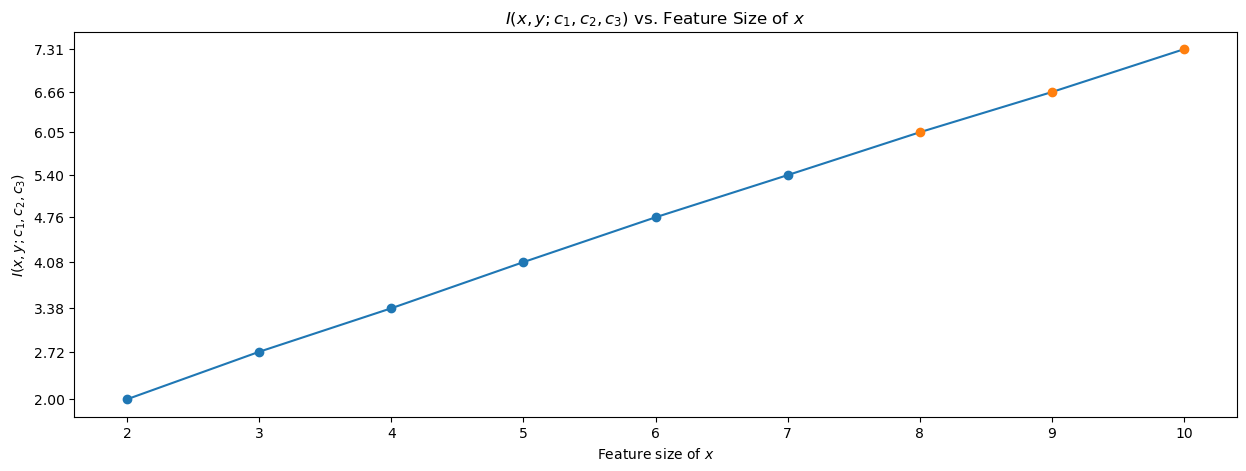

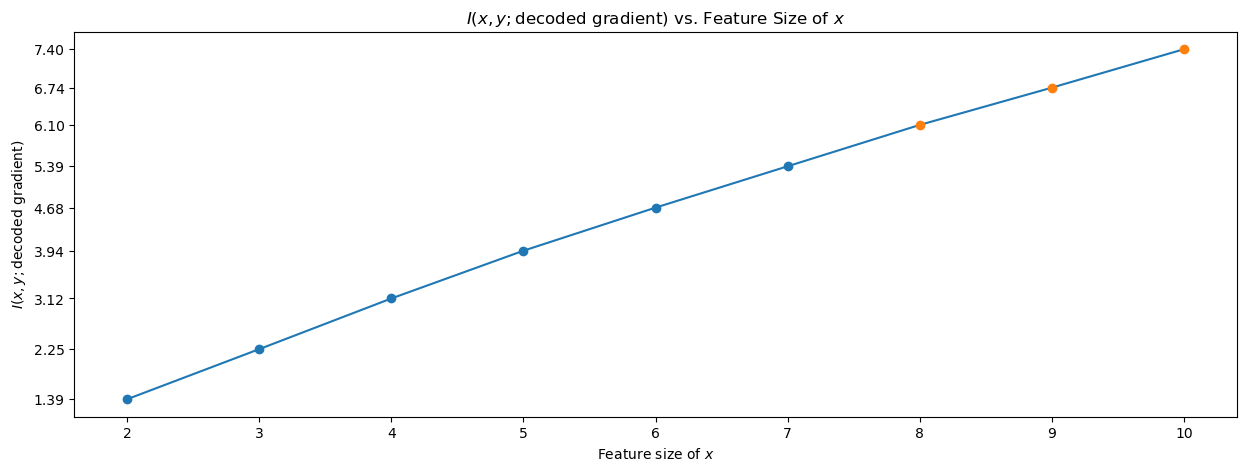

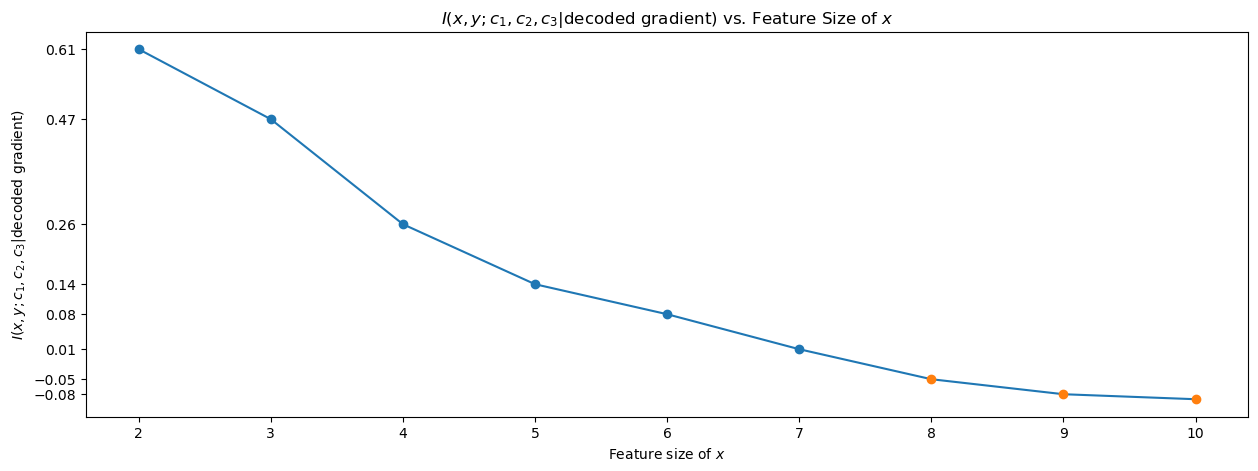

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(list(range(len(feature_arr))), [2,2.72, 3.38, 4.08, 4.76, 5.40, 6.05, 6.66, 7.31])
plt.scatter(list(range(6)), [2, 2.72, 3.38, 4.08, 4.76, 5.40])
plt.scatter(list(range(6, 9)), [6.05, 6.66, 7.31], zorder=10)
plt.xticks(list(range(len(feature_arr))), feature_arr)
plt.yticks([2, 2.72, 3.38, 4.08, 4.76, 5.40, 6.05, 6.66, 7.31])
plt.title('$I(x, y; c_1, c_2, c_3)$ vs. Feature Size of $x$')
plt.xlabel('Feature size of $x$')
plt.ylabel('$I(x, y; c_1, c_2, c_3)$')
plt.savefig('mi_secret_coeff_vs_feature_size.png', dpi=300)
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(list(range(len(feature_arr))), [1.39, 2.25, 3.12, 3.94, 4.68, 5.39, 6.10, 6.74, 7.40])
plt.scatter(list(range(len(feature_arr) - 3)), [1.39, 2.25, 3.12, 3.94, 4.68, 5.39])
plt.scatter(list(range(len(feature_arr) - 3, len(feature_arr))), [6.10, 6.74, 7.40], zorder=10)
plt.xticks(list(range(len(feature_arr))), feature_arr)
plt.yticks([1.39, 2.25, 3.12, 3.94, 4.68, 5.39, 6.10, 6.74, 7.40])
plt.title('$I(x, y; \mathrm{decoded} \ \mathrm{gradient})$ vs. Feature Size of $x$')
plt.xlabel('Feature size of $x$')
plt.ylabel('$I(x, y; \mathrm{decoded} \ \mathrm{gradient})$')
plt.savefig('mi_decoded_grad_vs_feature_size.png', dpi=300)
plt.show()

plt.figure(figsize=(15, 5))
sub_array = np.asarray([2,2.72, 3.38, 4.08, 4.76, 5.40, 6.05, 6.66, 7.31]) - np.asarray([1.39, 2.25, 3.12, 3.94, 4.68, 5.39, 6.10, 6.74, 7.40])
plt.plot(list(range(len(feature_arr))), sub_array)
plt.scatter(list(range(len(sub_array[:-3]))), sub_array[:-3])
plt.scatter(list(range(len(sub_array[:-3]), len(sub_array))), sub_array[-3:], zorder=10)
plt.xticks(list(range(len(feature_arr))), feature_arr)
plt.yticks(sub_array[:-1])
plt.title('$I(x, y; c_1, c_2, c_3 | \mathrm{decoded} \ \mathrm{gradient})$ vs. Feature Size of $x$')
plt.xlabel('Feature size of $x$')
plt.ylabel('$I(x, y; c_1, c_2, c_3 | \mathrm{decoded} \ \mathrm{gradient})$')
plt.savefig('mi_secret_coeff_cond_decoded_grad_vs_feature_size.png', dpi=300)
plt.show()